# CL Lac / IRC+50488

We will analyse the CHARA/MIRC data of CL Lac / IRC+50448, a Mira type AGB star. The data, which have been published in [Chiavassa et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A..23C/abstract), are available on [OIdB](https://oidb.jmmc.fr/search.html?conesearch=IRC%2B50448%2CJ2000%2C2%2Carcmin&perpage=50&instrument=MIRC&cs_radius_unit=arcmin&cs_equinox=J2000&order=t_min&caliblevel=3&category=SCIENCE&cs_radius=2&cs_position=IRC%2B50448).

In this tutorial, you should:
- load the data and display them
- fit a uniform disk model
- fit a limb-darkenend disk model
- add oblatness to the star shape
- add a spot on the star surface


In [1]:
try:
    %matplotlib pylab
    print('pylab')
except:
    %matplotlib widget
    print('widget')
    
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import time
try:
    # -- global installation\n",
    import pmoired
    from pmoired import tellcorr
    print('global installation')
except:
    # -- local installation
    import sys
    # -- where is your local version of PMOIRED
    sys.path = ['../pmoired'] + sys.path
    import __init__ as pmoired
    import tellcorr
    import dpfit
    print('local installation')
import CL_Lac

from importlib import reload
def showAnswer(x):
    print('### solution ###')
    print(x)
    print('### execution ###')
    exec(x, globals())

widget
[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
local installation


# Load and preview files

OIFITS data are in `./CL_Lac`. use `oi = pmoired.OI(...)` to load the files and construct your object.

to see / execute answer: ```showAnswer(CL_Lac.load)```

### solution ###
directory = './CL_Lac/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('viscal.fits')]
display(files)
oi = pmoired.OI(files)
oi.show(logV=True) # possible with 'logV=True' to see low visibilities
### execution ###


['./CL_Lac/mircx02796_oifits_viscal.fits',
 './CL_Lac/mircx02736_oifits_viscal.fits',
 './CL_Lac/mircx02706_oifits_viscal.fits',
 './CL_Lac/mircx02826_oifits_viscal.fits',
 './CL_Lac/mircx02330_oifits_viscal.fits',
 './CL_Lac/mircx02766_oifits_viscal.fits',
 './CL_Lac/mircx02856_oifits_viscal.fits']

loadOI: loading ./CL_Lac/mircx02796_oifits_viscal.fits
  > insname: "MIRCX" targname: "IRC+50448" pipeline: ""
  > MJD: (19,) [ 58692.481759218324 .. 58692.48178687777 ]
  > E1-E2-S1-S2-W1-W2 | WL: (8,) [ 1.509 .. 1.719 ] um (R~54) {'FLUX': 6, 'T3': 20, 'VIS': 15, 'VIS2': 15} | TELL: False 
loadOI: loading ./CL_Lac/mircx02736_oifits_viscal.fits
  > insname: "MIRCX" targname: "IRC+50448" pipeline: ""
  > MJD: (13,) [ 58692.47748903858 .. 58692.47784971837 ]
  > E1-E2-S1-S2-W1-W2 | WL: (8,) [ 1.509 .. 1.719 ] um (R~54) {'FLUX': 6, 'T3': 20, 'VIS': 15, 'VIS2': 15} | TELL: False 
loadOI: loading ./CL_Lac/mircx02706_oifits_viscal.fits
  > insname: "MIRCX" targname: "IRC+50448" pipeline: ""
  > MJD: (6,) [ 58692.475809605785 .. 58692.475894827025 ]
  > E1-E2-S1-S2-W1-W2 | WL: (8,) [ 1.509 .. 1.719 ] um (R~54) {'FLUX': 6, 'T3': 20, 'VIS': 15, 'VIS2': 15} | TELL: False 
loadOI: loading ./CL_Lac/mircx02826_oifits_viscal.fits
  > insname: "MIRCX" targname: "IRC+50448" pipeline: ""
  > MJD: (13,)

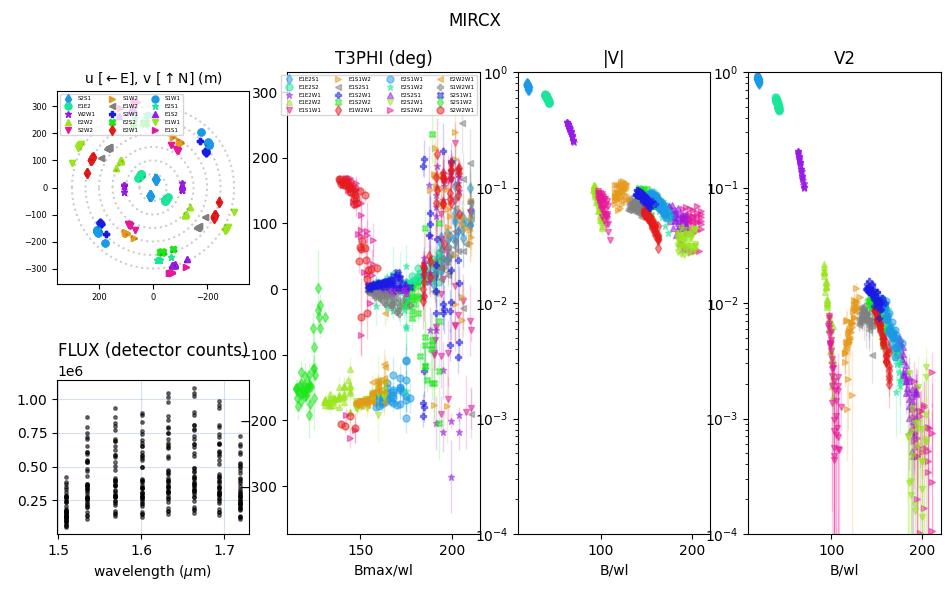

In [2]:
# showAnswer(CL_Lac.load)

# Uniform disk fit

Fit the `V2` data with a uniform disk diameter model (`ud`) and show the result.

When you setup the fit, you can use `'max relative error':{'V2':0.5}` to ignore the suqred visibilities with uncertainites larger than 50%

to see / execute answer: ```showAnswer(CL_Lac.udfit)```

### solution ###
oi.setupFit({'obs':['V2'],'max relative error':{'V2':0.5}})
oi.doFit({'star,ud':3}) # try several first values
oi.show(logV=True)
### execution ###
[dpfit] 1 FITTED parameters: ['star,ud']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb  6 14:48:45 2023 001/001 CHI2: 2.6718e+02|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 17 function calls ( 1.712 ms on average)
# -- degrees of freedom: 530
# -- reduced chi2: 47.337450482425986
{'star,ud':2.5018, # +/- 0.0058
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
            0  
 0:star,ud ### 


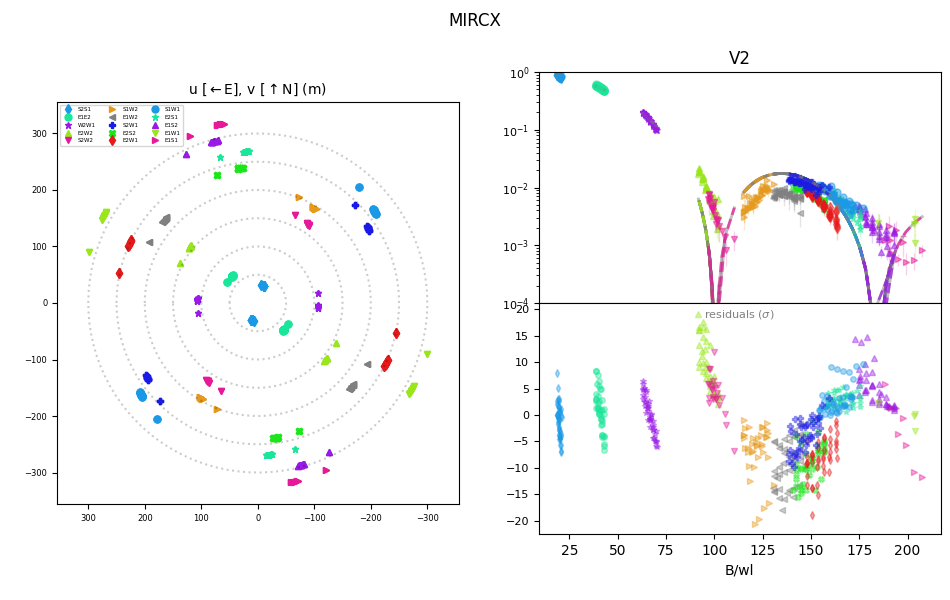

In [3]:
# showAnswer(CL_Lac.udfit)

# Limb darkened disk using 4-parameters

from [Claret (2000)](https://ui.adsabs.harvard.edu/abs/2000A%26A...363.1081C), table [J/A+A/363/1081/atlas](https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/363/1081/atlas&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa) get the 4-coef CLD parameters: $I(\mu)/I(1) = 1-\sum_{k=1}^{4}a_k(1-\mu^{k/2})$. In this context, $\mu = \cos(\gamma) = \sqrt{1-r^2}$, $\gamma$ being the angle between the line of sight and the emergent intensity and $r$ the normalised radial distance from the centre of the star to its limb. 

Based on the stellar parameters in [Chiavassa et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A..23C/abstract), you can use Teff=3500K and logg=1.0 in the H band for MIRCX.

reminder: in `PMOIRED`, you can describe a disk with arbitrary profile using `diam` and `profile`. The diameter is in milliarcseconds, and the profile is a string using special names `$R` and `$MU` and any additional parameters you need. You should first fix the LD parameters (using `doNotFit=[...]` for instance), then try to fit them: the LD parameters are not reliably determined.

to see / execute answer: ```showAnswer(CL_Lac.ldc2000fit)```

### solution ###
oi.setupFit({'obs':['V2'], 'max relative error':{'V2':0.5}})
# -- Teff=3500, logg=1.0, fixed parameters
oi.doFit({'star,diam':2.5, 'star,profile':'1 - $A1*(1-$MU**1/2) - $A2*(1-$MU**2/2) - $A3*(1-$MU**3/2) - $A4*(1-$MU**4/2)', 'A1':1.5899, 'A2':-1.6835, 'A3':1.0073, 'A4':-0.2389}, doNotFit=['A1', 'A2', 'A3', 'A4'])
oi.show(logV=True, imFov=5)

# -- Teff=3500, logg=1.0, let the parameters free
#oi.doFit({'star,diam':2.5, 'star,profile':'1 - $A1*(1-$MU**1/2) - $A2*(1-$MU**2/2) - $A3*(1-$MU**3/2) - $A4*(1-$MU**4/2)',
#            'A1':1.5899, 'A2':-1.6835, 'A3':1.0073, 'A4':-0.2389})
#oi.show(logV=True, imFov=5)

### execution ###
[dpfit] 1 FITTED parameters: ['star,diam']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb  6 14:49:42 2023 001/001 CHI2: 2.8130e+01|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 11 function calls ( 4.193 ms on average)
# -- degrees of freedom: 53

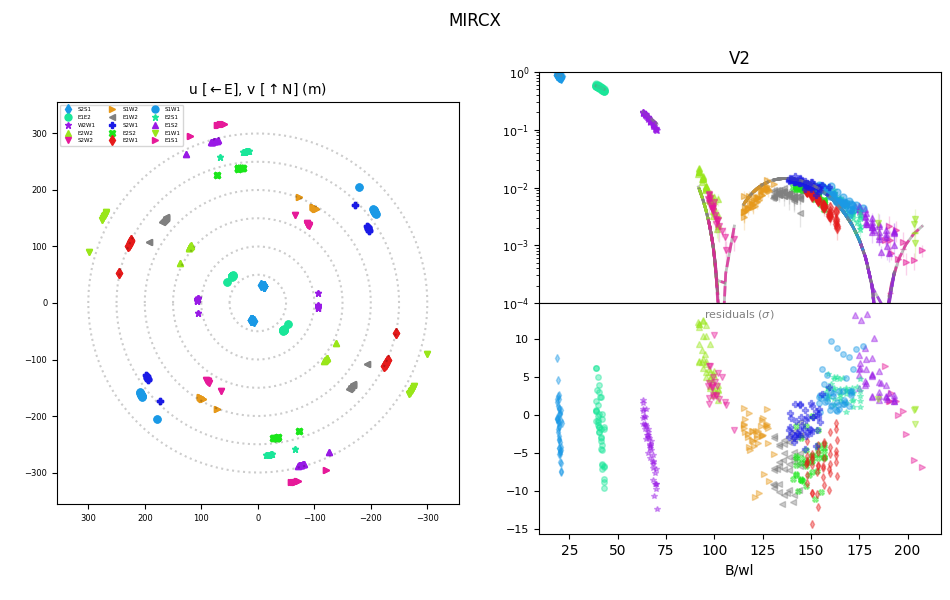

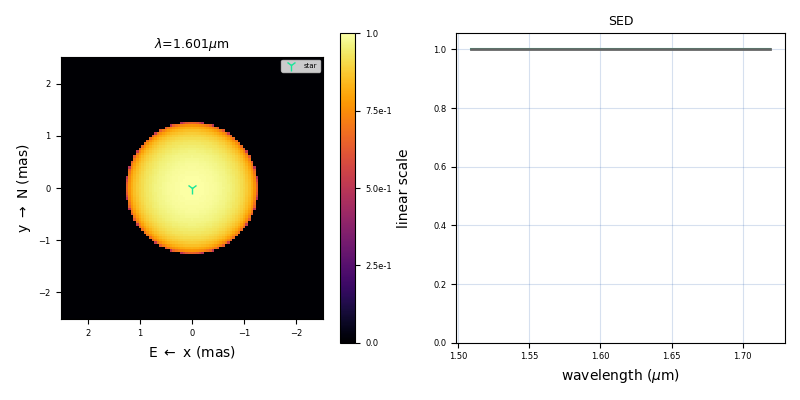

In [4]:
# showAnswer(CL_Lac.ldc2000fit)

## Adding prior to help fit the LD parameters
To help fit the LD parameters, we can add the constrain that $|a_k|<2$ for instance. This is done using the `prior` keyword in `doFit`: we pass a list of priors as tuples: `prior=[('diam', '<', 3), ...]` (no `$`!). 

Question: Can you tell if the fit is reliable? why?

to see / execute answer: ```showAnswer(CL_Lac.ldc2000fitprior)```

### solution ###
oi.setupFit({'obs':['V2'], 'max relative error':{'V2':0.5}})
m = {'star,diam':2.5, 
    'star,profile':'1 - $A1*(1-$MU**1/2) - $A2*(1-$MU**2/2) - $A3*(1-$MU**3/2) - $A4*(1-$MU**4/2)', 
    'A1':1.5899, 
    'A2':-1.6835, 
    'A3':1.0073, 
    'A4':-0.2389}
oi.doFit(m, prior=[('np.abs(A1)', '<', 2), ('np.abs(A2)', '<', 2), ('np.abs(A3)', '<', 2), ('np.abs(A4)', '<', 2)])
oi.show(logV=True, imFov=5)
### execution ###
[dpfit] 5 FITTED parameters: ['A1', 'A2', 'A3', 'A4', 'star,diam']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb  6 14:49:57 2023 001/000 CHI2: 2.8130e+01|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 2057 function calls ( 3.685 ms on average)
# -- degrees of freedom: 530
# -- reduced chi2: 17.488665418867388
{'A1':          -0.14, # +/- 4.79
'A2':          2.08, # +/- 0.18
'A3':          1.28, # +/- 0.42
'A4':          -2.25, # +/- 0.18
'star,diam':   2.79

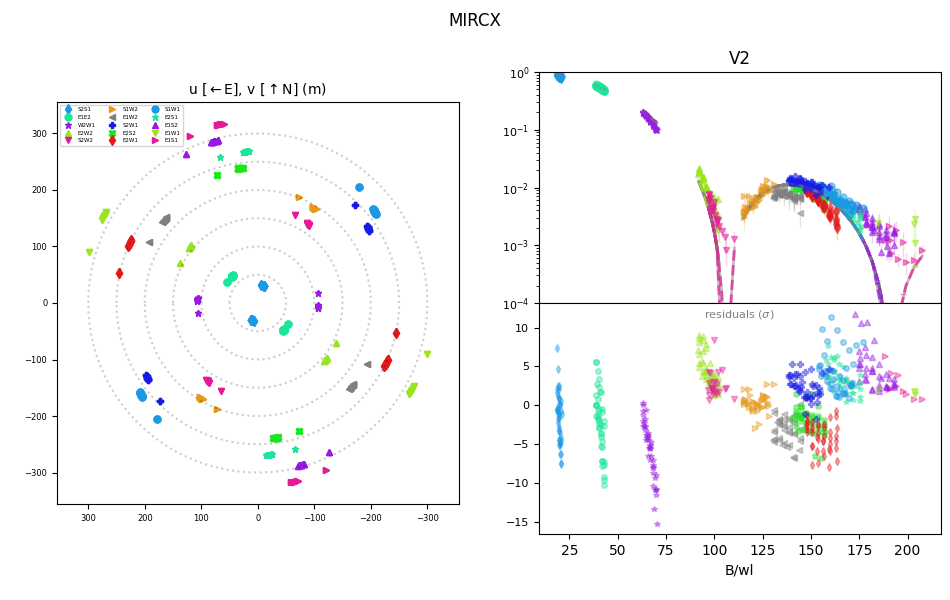

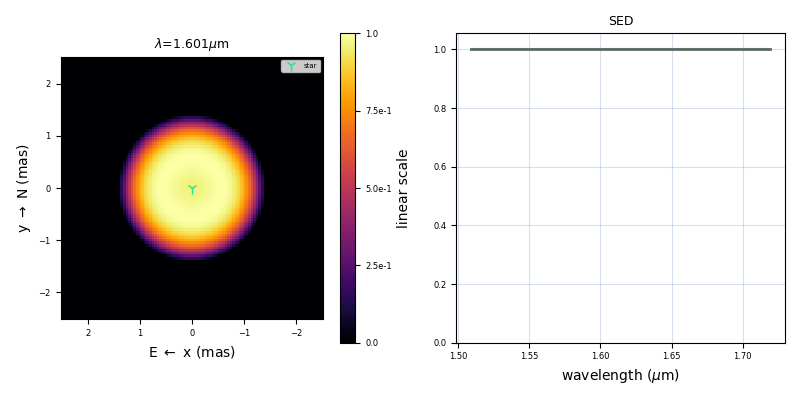

In [5]:
# showAnswer(CL_Lac.ldc2000fitprior)

# Limb darkening: power law

To fit the limb darkening, we need a simpler law (with less parameters): we can use a power law as described in [Hestroffer (1997)](https://ui.adsabs.harvard.edu/abs/1997A%26A...327..199H/abstract): $I[\mu]/I(1) = \mu**\alpha$

To be able to fit the LD coefficient (`alpha`), one needs data in the second lobe of visibility 

to see / execute answer: ```showAnswer(CL_Lac.ldalphafit)```

### solution ###
oi.setupFit({'obs':['V2'],'max relative error':{'V2':0.5}})
oi.doFit({'star,diam':2.5, 'star,profile':'$MU**$alpha', 'alpha':0.5})
oi.show(logV=True, imFov=5)
### execution ###
[dpfit] 2 FITTED parameters: ['alpha', 'star,diam']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb  6 14:50:31 2023 001/000 CHI2: 3.7161e+01|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 16 function calls ( 3.455 ms on average)
# -- degrees of freedom: 529
# -- reduced chi2: 20.213863138916306
{'alpha':       0.477, # +/- 0.022
'star,diam':   2.5878, # +/- 0.0066
'star,profile':'$MU**$alpha',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
              0   1  
 0:    alpha ###  74 
 1:star,diam  74 ### 


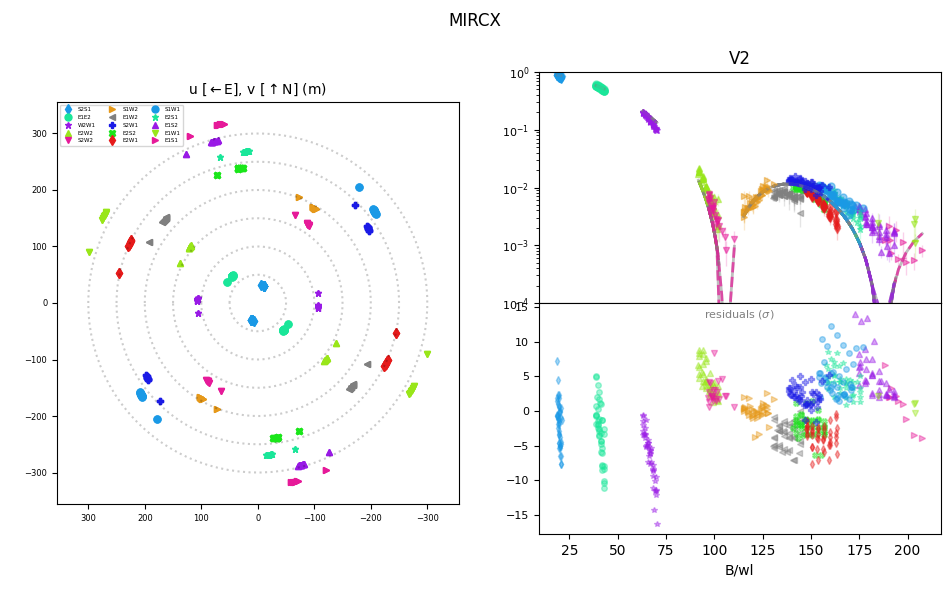

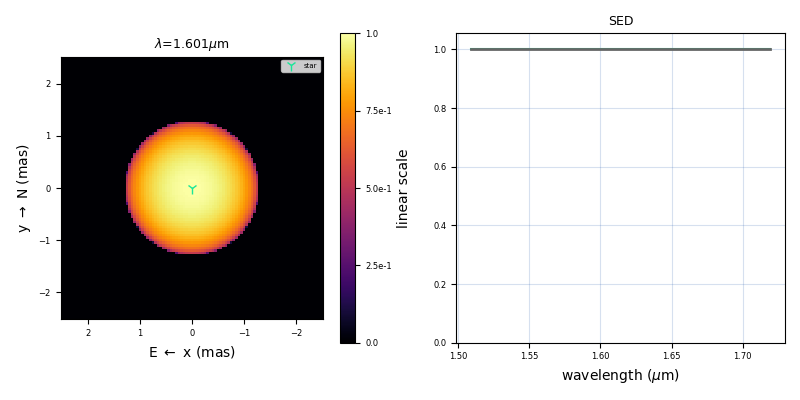

In [6]:
# showAnswer(CL_Lac.ldalphafit)

## Limb darkened oblate star

We can make the stellar shape oblate using `incl` and `projang`: `incl` is the "inclination", which means that the stellar shape will be an ellipse with large axis will have diameter `diam` and small axis cos(`incl`)$\times$`diam`. The large axis orientation is set by `projang`: 0 for North and 90 for East. All angles are in degrees.

to see / execute answer: ```showAnswer(CL_Lac.ldalphaoblatefit)```

### solution ###
oi.setupFit({'obs':['V2'],'max relative error':{'V2':0.5}})
oi.doFit({'star,diam':2.5, 'star,profile':'$MU**$alpha', 'alpha':0.5, 'star,projang':45, 'star,incl':20})
oi.show(logV=True, imFov=5)
### execution ###
[dpfit] 4 FITTED parameters: ['alpha', 'star,diam', 'star,incl', 'star,projang']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Mon Feb  6 14:50:42 2023 001/000 CHI2: 7.6706e+01|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 37 function calls ( 4.082 ms on average)
# -- degrees of freedom: 527
# -- reduced chi2: 14.717710448090854
{'alpha':       0.533, # +/- 0.018
'star,diam':   2.6612, # +/- 0.0079
'star,incl':   20.98, # +/- 0.66
'star,projang':85.12, # +/- 1.77
'star,profile':'$MU**$alpha',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                 0   1   2   3  
 0:       alpha ###  66  19  -2 
 1:   star,diam  66 ###  68  15 
 2:   star,incl  19  68 ###  

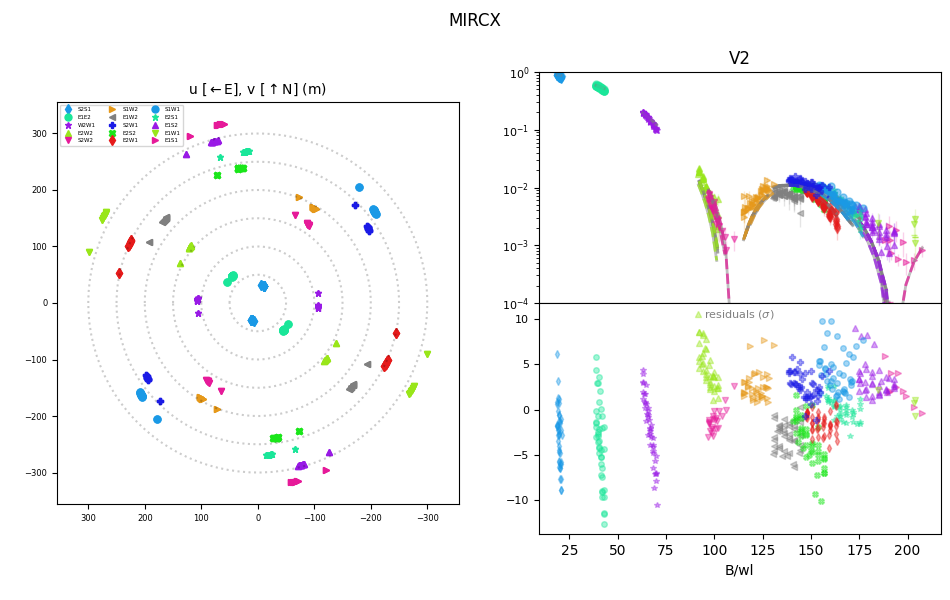

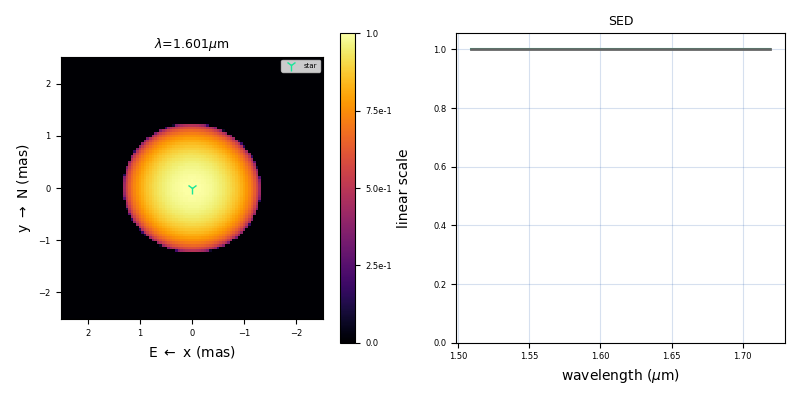

In [7]:
# showAnswer(CL_Lac.ldalphaoblatefit)

# Adding a spot to the limb-darkened oblate model

Add a spot to the previous best fit model (as a uniform disk for example). The spot must be able to be at different position on the star: use `x` and `y` (in mas). Also you should give it a flux `f` (total flux, not surface brightness!). 

Fit the `T3PHI` and `V2` data. if the spot gets too small, you can use a prior to force its size to be a reasonable fraction of the stellar size (between ~1/2 and ~1/4 of the size of the star, considering we have data in the third lobe).

You may find that the fit does not converge: it is because it is sensitive to the initial conditions, in particular the position of the spot. Try different initial positions.

to see / execute answer: ```showAnswer(CL_Lac.ldspotfit)```

### solution ###
# -- we also fit the closure phase
oi.setupFit({'obs':['T3PHI', 'V2'],'max relative error':{'V2':0.5}, 
                'max error':{'T3PHI':30}, 
                })
# -- taking the best model previously fitted
m = {'alpha':       0.533, # +/- 0.017
    'star,diam':   2.6611, # +/- 0.0075
    'star,incl':   20.93, # +/- 0.62
    'star,projang':85.31, # +/- 1.66
    'star,profile':'$MU**$alpha',
    }
# -- adding a spot
m.update({'spot,diam':0.8, 'spot,x':0.1, 'spot,y':0.1, 'spot,f':0.1})

prior = [('spot,diam', '<', 'star,diam/4'), 
          ('spot,diam', '>', 'star,diam/8'),
          ('spot,x**2+spot,y**2', '<', 'max(star,diam/2 - spot,diam/2, 0)**2')]

oi.doFit(m, prior=prior)
# -- using imMax to be able to see the stellar surface
oi.show(imFov=5, logV=True, imMax='99')
### execution ###
[dpfit] 8 FITTED parameters: ['alpha', 'spot,diam', 'spot,f', 'spot,x', 'spot,y', 'star,diam', 'star,incl', 'star,projang']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.op

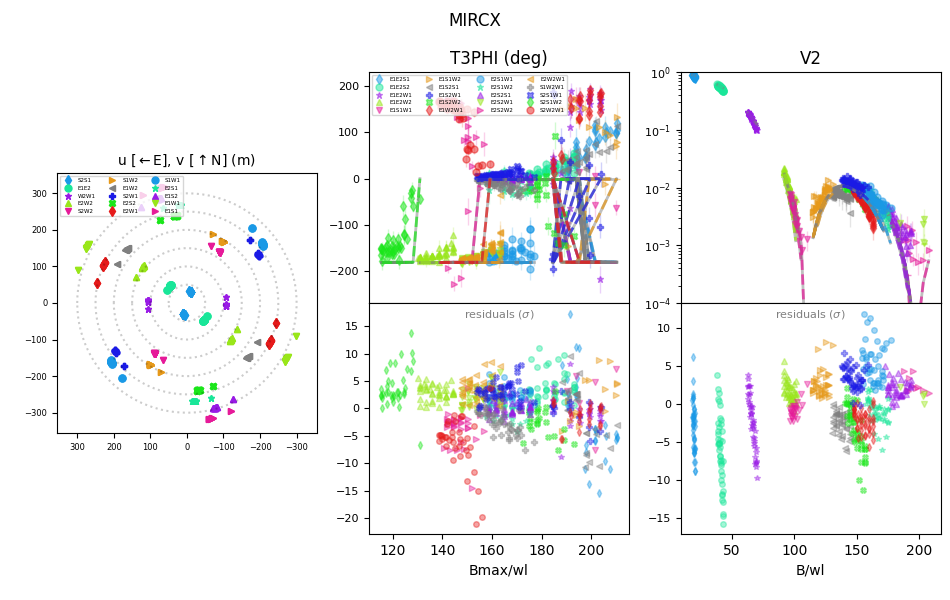

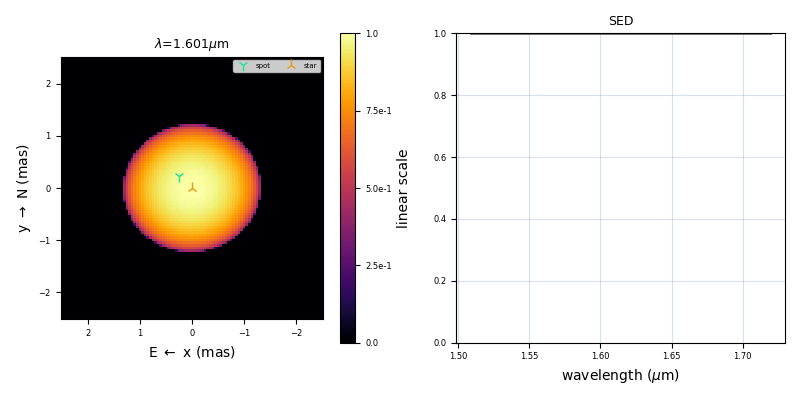

In [8]:
# showAnswer(CL_Lac.ldspotfit)

## `gridFit` to find the global best position for the spot

We saw the fit is sensitive to the initial position of the spot. Use `gridFit` to explore various initial positions. You can use `constrain=` to give a list of constrain on the initial parameters, and `prior=` which will be used while optimising the model.

compare you result to the ones presented in [Fig 2](https://www.aanda.org/articles/aa/full_html/2020/08/aa37832-20/F2.html) of the publication. 

to see / execute answer: ```showAnswer(CL_Lac.ldspotgrid)```

### solution ###
# -- we also fit the closure phase
oi.setupFit({'obs':['T3PHI', 'V2'],
                'max relative error':{'V2':0.5}, # ignore large uncertainties
                'max error':{'T3PHI':30}, # ignore large uncertainties
                })
# -- taking the best model previously fitted
m = {'alpha':       0.533, # +/- 0.017
    'star,diam':   2.6611, # +/- 0.0075
    'star,incl':   20.93, # +/- 0.62
    'star,projang':85.31, # +/- 1.66
    'star,profile':'$MU**$alpha',
    }
# -- adding a spot
m.update({'spot,diam':0.8, 'spot,x':0.0, 'spot,y':0.0, 'spot,f':0.1})

# -- prior on the size of the spot
prior = [('spot,diam', '<', 'star,diam/4'), 
          ('spot,diam', '>', 'star,diam/8'),
          ('spot,x**2+spot,y**2', '<', 'max(star,diam/2 - spot,diam/2, 0)**2')]

# -- we define our exploration pattern (random uniform)
expl = {'rand':{'spot,x':(-m['star,diam']/2, m['star,diam']/2), 'spot,y':(-m['star,diam']/2, m['star,diam']/2)}}

# -- we define additional constrain to t

/Users/amerand/Codes/PYTHON3/PMOIRED/tutorials/../pmoired/dpfit.py:505: RuntimeWarning: invalid value encountered in sqrt
  cor = np.sqrt(np.diag(cov))


/Users/amerand/Codes/PYTHON3/PMOIRED/tutorials/../pmoired/dpfit.py:505: RuntimeWarning: invalid value encountered in sqrt
  cor = np.sqrt(np.diag(cov))


Mon Feb  6 14:52:30 2023: [████████████████████████████████████████████████████████████]51/51  0s   left
Mon Feb  6 14:52:31 2023: it took 18.9s, 0.37s per fit on average [161.5 fit/minute]
fits to be taken into account: 45 / 51
  6 did not numerically converge
unique minima: 14 / 45 [~3.2 first guesses / minima]
  number of minima is OK compared to grid coarseness
------------
best fit: chi2= 9.737485522022501
{'alpha':       0.493, # +/- 0.021
'spot,diam':   0.142, # +/- 0.090
'spot,f':      0.01619, # +/- 0.00069
'spot,x':      0.119, # +/- 0.011
'spot,y':      -0.458, # +/- 0.013
'star,diam':   2.6606, # +/- 0.0076
'star,incl':   18.62, # +/- 0.53
'star,projang':93.44, # +/- 1.54
'star,profile':'$MU**$alpha',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                 0   1   2   3   4   5   6   7  
 0:       alpha ###  -8 -11  39 -70  76 -16  -5 
 1:   spot,diam  -8 ###  41  -1   8  -1  13  -2 
 2:      spot,f -11  41 ###  -5  18  -4   1 -14 
 3:      spot,x  39  -1  -5 ##

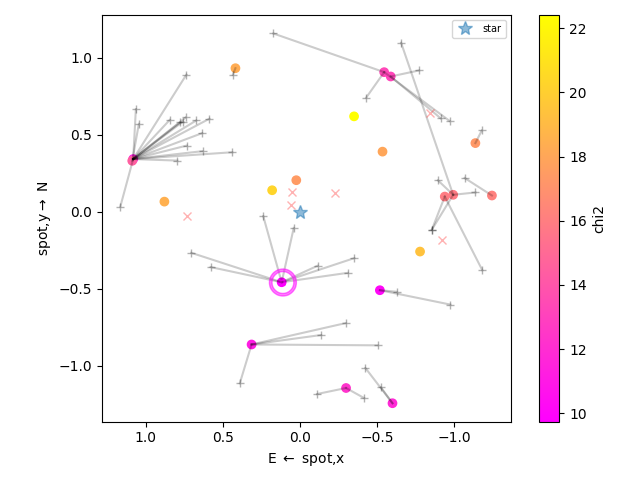

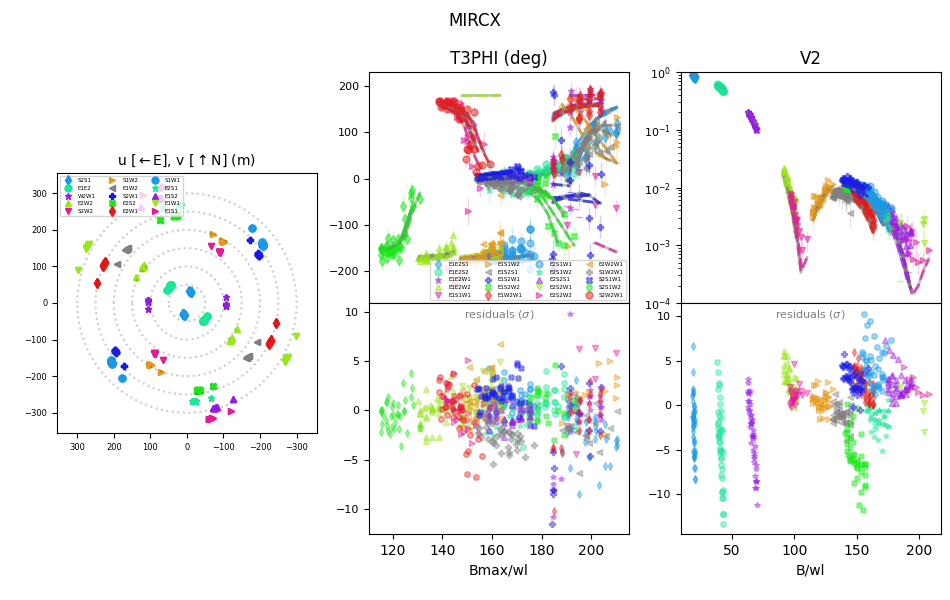

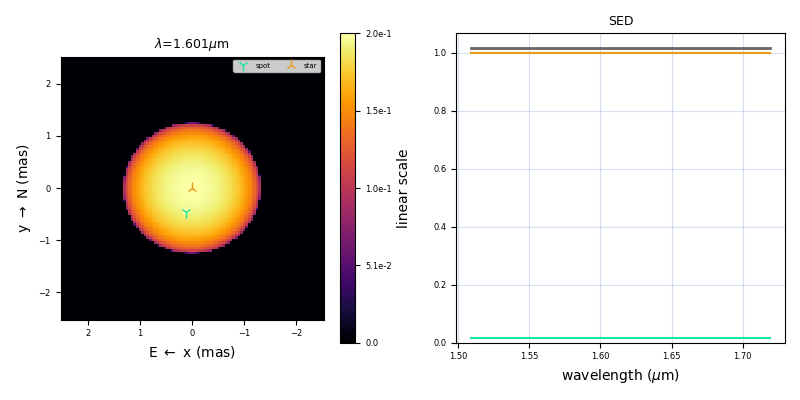

In [10]:
# showAnswer(CL_Lac.ldspotgrid)